# COGS 4290 Assignment 0

In [2]:
# imports
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
import pickle

## Problem 1: Lists and Matplotlib
A question of great intrigue in neuroscience is how do we mathematically describe the activity of individual neurons.  One attempt at this the Izhikevich model, which consists of 3 equations that model the dynamics of a neuron's membrane potential $V$.

$$
\frac{dV}{dt} = 0.04V^{2} + 5V + 140 - u + I
$$

$$
\frac{du}{dt} = a(bV - u)
$$

$$
if \ V \geq 30 \ mV, \ then \ \{V \leftarrow c; u \leftarrow u + d\}
$$

Here $u$ is a membrane recovery variable, $I$ is the input current, and $a$, $b$, $c$, and $d$ are free parameters.  Essentially, the first two equations model how the voltage $V$ and recovery variable $u$ change in time, while the third equation indicates that if the voltage reaches a certain threshold, it will be reset to some value $c$.  This reset is meant to symbolize the hyperpolarization that follows the firing of an action potential.

In this problem, we will simulate the Izhikevich model with different parameter sets to generate unique neuronal behaviors.  We will use the same constants and initial values for each part as defined below, with our simulations running over 300 ms.  For the input current, we will presume that there is 50 ms of no current followed by 250 ms of constant current at 10 mA.

In [2]:
# constants, initial values
Vthresh = 30           # threshold potential [mV]
V0 = -65               # initial potential [mV]
t0 = -50               # initial time [ms]
tf = 250               # final time [ms]
dt = 0.01              # time step [ms]
I_in = 10              # input current [mA]

To run simulations of the model, we will define a function that takes in several arguments for the initial conditions and parameter values and returns two lists, one that holds the membrane potential and one that holds the time at each step of the simulation, as well as the number of action potentials fired.

In [3]:
# Izhikevich model simulation
def Izh_model(V0, Vthresh, t0, tf, dt, a, b, c, d, I_in):
    V = V0                       # set initial voltage
    u0 = b * V0
    u = u0                       # set initial membrane recovery
    t = t0                       # set initial time
    Vlist = [V]                  # list holding voltage time-series
    tlist = [t]                  # list holding times
    action_potentials = 0        # number of action potentials
    
    # YOUR CODE HERE
    while t < tf:
        # step current
        if t < 0:
            I = 0
        else:
            I = I_in
        
        # check if threshold reached, reset
        if V >= Vthresh:
            V = c
            Vlist.append(V)
            action_potentials += 1
            
            u = u + d
            
            t += dt
            tlist.append(t)
            
        # update membrane potential
        dV = (0.04*(V**2) + 5*V + 140 - u + I) * dt
        V += dV
        Vlist.append(V)
        
        # update membrane recovery variable
        du = (a * (b*V - u)) * dt
        u += du
        
        # step forward time
        t += dt
        tlist.append(t)
    
    return Vlist, tlist, action_potentials
    

#### Part (a) Regular Spiking Neuron
Simulate the Izhekevich model with the parameters $a = 0.02$, $b = 0.2$, $c = -65 \ mV$, $d = 2$.  Input to the neuron a step current, $I = 0$ when $t < 0$ and $I = 10$ when $t \geq 0$.  Plot the results and indicate how many action potentials the neuron fired.  Make sure to label your axes, as well as indicate on your graph the reset and threshold potentials using dashed horizontal lines.

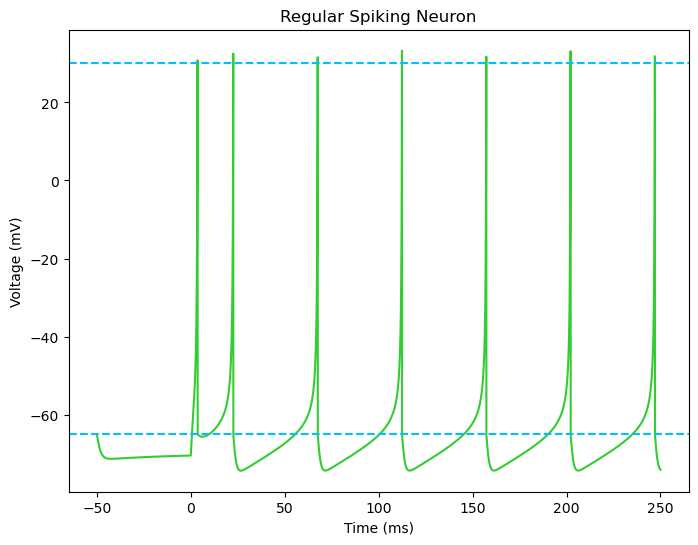

In [4]:
# YOUR CODE HERE
# parameters
a = 0.02
b = 0.2
c = -65    # [mV]
d = 8

# run the model
Vlist, tlist, action_potentials = Izh_model(V0, Vthresh, t0, tf, dt, a, b, c, d, I_in)

# graphing
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(tlist, Vlist, color='limegreen')
ax.axhline(y=c, c='deepskyblue', ls='--')
ax.axhline(y=Vthresh, c='deepskyblue', ls='--')
ax.set(xlabel='Time (ms)', ylabel='Voltage (mV)', title='Regular Spiking Neuron')
plt.show()

#### Part (b) Chattering Neuron
Simulate the Izhekevich model with the parameters $a = 0.02$, $b = 0.2$, $c = -50 \ mV$, $d = 2$.  Input to the neuron a step current, $I = 0$ when $t < 0$ and $I = 10$ when $t \geq 0$.  Plot the results and indicate how many action potentials the neuron fired.  Make sure to label your axes, as well as indicate on your graph the reset and threshold potentials using dashed horizontal lines.

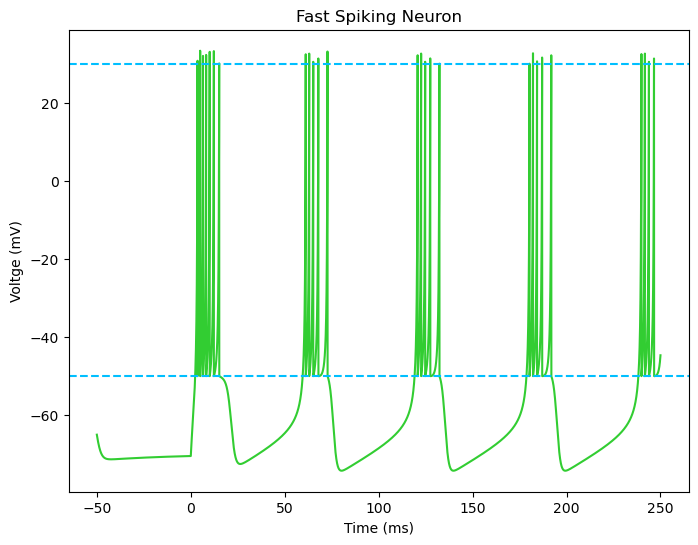

In [5]:
# YOUR CODE HERE
# parameters
a = 0.02
b = 0.2
c = -50   # [mV]
d = 2

# run the model
Vlist, tlist, action_potentials = Izh_model(V0, Vthresh, t0, tf, dt, a, b, c, d, I_in)

# graphing
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(tlist, Vlist, color='limegreen')
ax.axhline(y=c, c='deepskyblue', ls='--')
ax.axhline(y=Vthresh, c='deepskyblue', ls='--')
ax.set(xlabel='Time (ms)', ylabel='Voltge (mV)', title='Fast Spiking Neuron')
plt.show()

## Problem 2: Numpy and Multi-dimensional Data

We have data on the temperature profile of a lake in Switzerland, in the form of a 4-dimensional array.  The first dimension represents depth, the second length, the third width (all in meters), and the last dimension represents the day of the year (stating January 1st and ending December 31st).  We are interested in the dynamics of the temperature profile of the lake over the course of the year and want to answer the follwing.

Questions:
1) Find the day of the year where the average temperature of the entire lake is the coldest, warmest.
2) Plot the change in temperature of the lake averaged over the entire body of water as a time-series, taking the difference each day.
3) For each 10 meter layer of depth, find the standard deviation of temperatue over the year, treating each day as independent.
4) Averaging over the width, plot the 2-dimensional temperatue profile of the lake averaging over 1 week in the summer and 1 week in the winter.

Running the cell below will generate the data for use to analyze.

In [6]:
def gen_lake_data():
    temp_lake = np.zeros((50, 100, 70, 365), dtype=float)    # 50 meters depth, 100 meters length, 50 meters width, 365 days
    ones = np.ones((temp_lake.shape[1], temp_lake.shape[2]))
    
    # linear function of height
    h = np.arange(0, 50)
    temp_h = -0.3*h + 15
    
    # sinusoid on time
    day = np.arange(0, 365)
    temp_day = np.sin(np.radians(day) - 5*np.pi/6)
    
    for i in range(temp_lake.shape[0]):
        for j in range(temp_lake.shape[3]):
            np.random.seed(i*j)
            temp_lake[i,:,:,j] = temp_h[i] * temp_day[j] * ones * 0.8 + np.random.uniform(-1.0, 1.0, ones.shape) + 10   # randomly sample for each width and length
    
    return temp_lake

t_lake = gen_lake_data()

#### Part (a)
Find the day of the year where the average temperature of the entire lake is the coldest and the warmest.

In [1]:
day_cold = np.argmin(np.mean(t_lake, axis=(0, 1, 2)))
day_warm = np.argmax((np.mean(t_lake, axis=(0,1,2))))

print(f'Coldest day of the year = {day_cold}.')
print(f'Warmest day of the year = {day_warm}.')

NameError: name 'np' is not defined

#### Part (b)
Plot the change in temperature of the lake at heights 5 m and 40 m as a time-series, taking the difference each day.

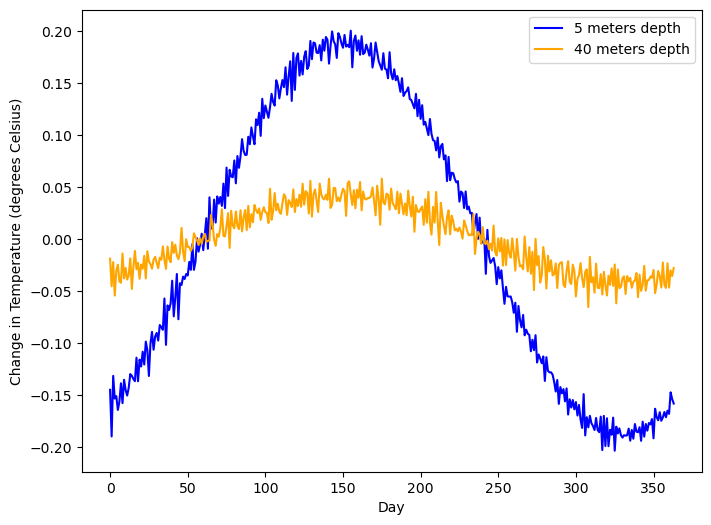

In [10]:
# YOUR CODE HERE
t_5m = t_lake[5, :, :, :]
t_40m = t_lake[40, :, :, :]

# graphing
fig, ax = plt.subplots(figsize=(8,6))


plt.plot(np.diff(np.mean(t_5m, axis=(0,1))), c='blue', label='5 meters depth')
plt.plot(np.diff(np.mean(t_40m, axis=(0,1))), c='orange', label='40 meters depth')
ax.set(xlabel='Day', ylabel='Change in Temperature (degrees Celsius)')
ax.legend()

#### Part (c)
For each 10 meter layer of depth, find the standard deviation of temperature over the year, treating each day as independent.

In [11]:
# YOUR CODE HERE
d1 = t_lake[:10, :, :, :]
d2 = t_lake[10:20, :, :, :]
d3 = t_lake[20:30, :, :, :]
d4 = t_lake[30:40, :, :, :]
d5 = t_lake[40, :, :, :]

d1_stdev = np.std(np.mean(d1, axis=(0,1)))
d2_stdev = np.std(np.mean(d2, axis=(0,1)))
d3_stdev = np.std(np.mean(d3, axis=(0,1)))
d4_stdev = np.std(np.mean(d4, axis=(0,1)))
d5_stdev = np.std(np.mean(d5, axis=(0,1)))

print(f'Standard deviation of depth 0-10 meters = {d1_stdev}.')
print(f'Standard deviation of depth 10-20 meters = {d2_stdev}.')
print(f'Standard deviation of depth 20-30 meters = {d3_stdev}.')
print(f'Standard deviation of depth 30-40 meters = {d4_stdev}.')
print(f'Standard deviation of depth 40-50 meters = {d5_stdev}.')

Standard deviation of depth 0-10 meters = 7.698131601972972.
Standard deviation of depth 10-20 meters = 6.006087734011565.
Standard deviation of depth 20-30 meters = 4.3144816695437305.
Standard deviation of depth 30-40 meters = 2.6223276679387464.
Standard deviation of depth 40-50 meters = 1.691508023225515.


#### Part (d)
Selecting a width in the middle of the lake, plot the two-dimensional temperature profile of the lake on 1 day in the summer and 1 day in the winter.  Also, averaging over the width of the lake, plot the temperature profile averaged over 1 week in the summer and 1 week in the winter.

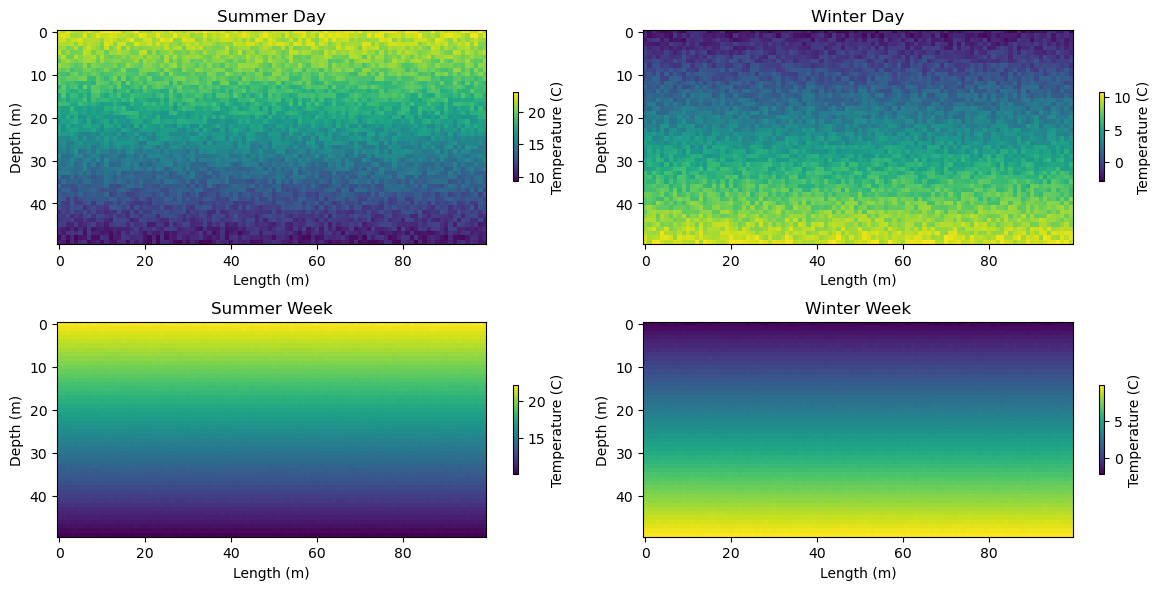

In [12]:
# YOUR CODE HERE
t_summer_day = t_lake[:, :, 25, 239]
t_winter_day = t_lake[:, :, 25, 61]

summer_week = t_lake[:, :, :, 235:242]
winter_week = t_lake[:, :, :, 58:65]
t_summer_week = np.mean(summer_week, axis=(2,3))
t_winter_week = np.mean(winter_week, axis=(2,3))

# graphing
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
tsd = ax[0, 0].imshow(t_summer_day)
ax[0,0].set(title='Summer Day', xlabel='Length (m)', ylabel='Depth (m)')
fig.colorbar(tsd, shrink=0.35, label='Temperature (C)')
twd = ax[0, 1].imshow(t_winter_day)
ax[0,1].set(title='Winter Day', xlabel='Length (m)', ylabel='Depth (m)')
fig.colorbar(twd, shrink=0.35, label='Temperature (C)')
tsw = ax[1, 0].imshow(t_summer_week)
ax[1,0].set(title='Summer Week', xlabel='Length (m)', ylabel='Depth (m)')
fig.colorbar(tsw, shrink=0.35, label='Temperature (C)')
tww = ax[1, 1].imshow(t_winter_week)
ax[1,1].set(title='Winter Week', xlabel='Length (m)', ylabel='Depth (m)')
fig.colorbar(tww, shrink=0.35, label='Temperature (C)')

plt.tight_layout()
plt.show()

## Problem 3: Pandas

Imagine you work for a professional football club.  Your team just lost your best player, so the owner has tasked you with identifying potential replacement players that your team can sign.  Specifically, the manager has instructed you that they are looking for players with the following qualifications:

1) Midfielders: Only look at players who have 'MF' listed as a position they can play ('Pos').
2) Injury-Free: Only look at players who played more that 10 90s in the previous season ('90s').
3) Above average passing completion percentage ('Total_CMP%').
4) Above average key passes per 90 minutes ('KP').
5) Above average progressive passing distance per 90 minutes ('Total_PrgDist').
6) Youth: Only look at players under 25 years old ('Age').

Run the following code to load in a dataset containing player statistics from the previous season.

In [13]:
def load_fbref_data():
    # load in data from html
    passing_t5 = pd.read_html('https://fbref.com/en/comps/Big5/2022-2023/passing/players/2022-2023-Big-5-European-Leagues-Stats')[0]
    # relabel column names
    passing_t5.columns = [x[0] + '_' + x[1] if 'Unnamed' not in x[0] else x[1] for x in passing_t5.columns]
    # clean up ages
    passing_t5['Age'] = [x.split('-')[0] if type(x)==str else '100' for x in passing_t5.Age]
    # convert from strings to numerics
    num_cols = ['Age', 'Born', '90s', 'Total_Cmp', 'Total_Att', 'Total_Cmp%', 'Total_TotDist', 'Total_PrgDist', 'Short_Cmp', 'Short_Att', 'Short_Cmp%', 
                'Medium_Cmp', 'Medium_Att', 'Medium_Cmp%', 'Long_Cmp', 'Long_Att', 'Long_Cmp%', 'Ast', 'xAG', 'xA', 'A-xAg', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP']
    for c in passing_t5.columns:
        if c in num_cols:
            passing_t5[c] = pd.to_numeric(passing_t5[c], errors='coerce')
    
    return passing_t5

dataframe = load_fbref_data()
dataframe

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Total_Cmp,Total_Att,Total_Cmp%,Total_TotDist,Total_PrgDist,Short_Cmp,Short_Att,Short_Cmp%,Medium_Cmp,Medium_Att,Medium_Cmp%,Long_Cmp,Long_Att,Long_Cmp%,Ast,xAG,xA,A-xAG,KP,1/3,PPA,CrsPA,PrgP,Matches
0,1,Brenden Aaronson,us USA,"MF,FW",Leeds United,eng Premier League,21.0,2000.0,26.4,592.0,797.0,74.3,7577.0,2182.0,346.0,423.0,81.8,150.0,195.0,76.9,25.0,65.0,38.5,3.0,4.2,2.6,-1.2,46.0,47.0,16.0,4.0,86.0,Matches
1,2,Paxten Aaronson,us USA,"MF,DF",Eint Frankfurt,de Bundesliga,18.0,2003.0,1.9,51.0,71.0,71.8,659.0,109.0,36.0,38.0,94.7,14.0,23.0,60.9,1.0,6.0,16.7,0.0,0.0,0.1,0.0,1.0,3.0,0.0,0.0,6.0,Matches
2,3,James Abankwah,ie IRL,DF,Udinese,it Serie A,18.0,2004.0,0.7,23.0,29.0,79.3,375.0,79.0,14.0,15.0,93.3,6.0,8.0,75.0,2.0,5.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matches
3,4,George Abbott,eng ENG,MF,Tottenham,eng Premier League,16.0,2005.0,0.0,1.0,1.0,100.0,8.0,0.0,1.0,1.0,100.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matches
4,5,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,34.0,1987.0,37.0,1679.0,2031.0,82.7,32967.0,13407.0,490.0,571.0,85.8,1006.0,1117.0,90.1,155.0,279.0,55.6,2.0,1.0,0.9,+1.0,13.0,155.0,5.0,0.0,215.0,Matches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,2885,Martin Ødegaard,no NOR,MF,Arsenal,eng Premier League,23.0,1998.0,34.7,1449.0,1804.0,80.3,22540.0,6014.0,759.0,873.0,86.9,518.0,617.0,84.0,110.0,175.0,62.9,7.0,8.1,7.9,-1.1,76.0,135.0,91.0,4.0,266.0,Matches
3000,2886,Milan Đurić,ba BIH,FW,Hellas Verona,it Serie A,32.0,1990.0,15.2,268.0,523.0,51.2,3119.0,740.0,186.0,336.0,55.4,54.0,119.0,45.4,5.0,13.0,38.5,1.0,1.3,0.9,-0.3,21.0,27.0,5.0,0.0,29.0,Matches
3001,2887,Filip Đuričić,rs SRB,"MF,FW",Sampdoria,it Serie A,30.0,1992.0,24.1,586.0,758.0,77.3,9599.0,2169.0,302.0,347.0,87.0,211.0,254.0,83.1,52.0,86.0,60.5,0.0,1.9,1.6,-1.9,34.0,50.0,18.0,4.0,77.0,Matches
3002,2888,Blanco,NaN,MF,Cádiz,es La Liga,22.0,2000.0,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches


#### Part (a)
First, let's clean up our dataset a little bit.  There are numerous columns we are not concerned with, so let's just remove them.  Drop all of the columns in the list below from our dataframe.

In [14]:
cols_to_drop = ['Rk', 'Born', 'xAG', 'A-xAG', '1/3', 'PPA', 'CrsPA', 'Matches']


# YOUR CODE HERE
df = dataframe.drop(columns=cols_to_drop)
df

,Player,Nation,Pos,Squad,Comp,Age,90s,Total_Cmp,Total_Att,Total_Cmp%,Total_TotDist,Total_PrgDist,Short_Cmp,Short_Att,Short_Cmp%,Medium_Cmp,Medium_Att,Medium_Cmp%,Long_Cmp,Long_Att,Long_Cmp%,Ast,xA,KP,PrgP
0,Brenden Aaronson,us USA,"MF,FW",Leeds United,eng Premier League,21.0,26.4,592.0,797.0,74.3,7577.0,2182.0,346.0,423.0,81.8,150.0,195.0,76.9,25.0,65.0,38.5,3.0,2.6,46.0,86.0
1,Paxten Aaronson,us USA,"MF,DF",Eint Frankfurt,de Bundesliga,18.0,1.9,51.0,71.0,71.8,659.0,109.0,36.0,38.0,94.7,14.0,23.0,60.9,1.0,6.0,16.7,0.0,0.1,1.0,6.0
2,James Abankwah,ie IRL,DF,Udinese,it Serie A,18.0,0.7,23.0,29.0,79.3,375.0,79.0,14.0,15.0,93.3,6.0,8.0,75.0,2.0,5.0,40.0,0.0,0.0,0.0,0.0
3,George Abbott,eng ENG,MF,Tottenham,eng Premier League,16.0,0.0,1.0,1.0,100.0,8.0,0.0,1.0,1.0,100.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0
4,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,34.0,37.0,1679.0,2031.0,82.7,32967.0,13407.0,490.0,571.0,85.8,1006.0,1117.0,90.1,155.0,279.0,55.6,2.0,0.9,13.0,215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,Martin Ødegaard,no NOR,MF,Arsenal,eng Premier League,23.0,34.7,1449.0,1804.0,80.3,22540.0,6014.0,759.0,873.0,86.9,518.0,617.0,84.0,110.0,175.0,62.9,7.0,7.9,76.0,266.0
3000,Milan Đurić,ba BIH,FW,Hellas Verona,it Serie A,32.0,15.2,268.0,523.0,51.2,3119.0,740.0,186.0,336.0,55.4,54.0,119.0,45.4,5.0,13.0,38.5,1.0,0.9,21.0,29.0
3001,Filip Đuričić,rs SRB,"MF,FW",Sampdoria,it Serie A,30.0,24.1,586.0,758.0,77.3,9599.0,2169.0,302.0,347.0,87.0,211.0,254.0,83.1,52.0,86.0,60.5,0.0,1.6,34.0,77.0
3002,Blanco,NaN,MF,Cádiz,es La Liga,22.0,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


#### Part (b)
Now, let's begin filtering our data.  First, let's determine how many players qualify based on our first 2 criteria.  Filter out all players who are not midfielders or who played fewer than 10 90s last season.  Report the number of players who qualify from each league ('Comp').

In [15]:
# YOUR CODE HERE
# select midfielders
df_mf = df.query("'MF' in Pos")
# only want players with > 10 90s
df_qualifying = df_mf[df_mf['90s'] > 10.0]
# each league
for comp in df_qualifying['Comp'].unique():
    print(f'Qualifying players from league {comp}, = {len(df_qualifying[df_qualifying["Comp"] == comp].index)}')

Qualifying players from league fr Ligue 1, = 73
Qualifying players from league eng Premier League, = 63
Qualifying players from league es La Liga, = 70
Qualifying players from league de Bundesliga, = 56
Qualifying players from league it Serie A, = 73


#### Part (c)
For the next 3 criteria, we want to judge individual performance in relation to the performance of other players.  Also, we want to look statistics based on a per 90 minute rate.  Using the data we have available, create two new columns ('KP_per90' and 'Total_PrgDist_per90') and populate them with the rate data we want.  Then, filter the data further and identify the list of players who had above average passing completion percentage, key passes per 90 minutes, and progressive passing distance per 90 minutes.  Also report the means for these three statistics.

In [16]:
# YOUR CODE HERE
df_qualifying['Total_PrgDist_per90'] = df_qualifying['Total_PrgDist'] / df_qualifying['90s']
df_qualifying['KP_per90'] = df_qualifying['KP'] / df_qualifying['90s']
df_filt = df_qualifying[(df_qualifying['Total_PrgDist_per90'] > df_qualifying['Total_PrgDist_per90'].mean()) & 
                        (df_qualifying['KP_per90'] > df_qualifying['KP_per90'].mean()) & 
                        (df_qualifying['Total_Cmp%'] > df_qualifying['Total_Cmp%'].mean())]
df_filt

,Player,Nation,Pos,Squad,Comp,Age,90s,Total_Cmp,Total_Att,Total_Cmp%,Total_TotDist,Total_PrgDist,Short_Cmp,Short_Att,Short_Cmp%,Medium_Cmp,Medium_Att,Medium_Cmp%,Long_Cmp,Long_Att,Long_Cmp%,Ast,xA,KP,PrgP,Total_PrgDist_per90,KP_per90
34,Álvaro Aguado,es ESP,MF,Valladolid,es La Liga,26.0,21.0,930.0,1142.0,81.4,18906.0,5096.0,359.0,404.0,88.9,371.0,429.0,86.5,174.0,246.0,70.7,2.0,2.0,35.0,139.0,242.666667,1.666667
63,Luis Alberto,es ESP,MF,Lazio,it Serie A,29.0,27.1,1640.0,1988.0,82.5,25338.0,8690.0,905.0,986.0,91.8,560.0,646.0,86.7,116.0,238.0,48.7,7.0,6.3,66.0,248.0,320.664207,2.435424
66,Thiago Alcántara,es ESP,MF,Liverpool,eng Premier League,31.0,13.9,946.0,1097.0,86.2,17219.0,4988.0,433.0,466.0,92.9,346.0,392.0,88.3,136.0,172.0,79.1,0.0,1.3,17.0,120.0,358.848921,1.223022
232,Nicolò Barella,it ITA,MF,Inter,it Serie A,25.0,29.0,1306.0,1601.0,81.6,21320.0,6648.0,684.0,773.0,88.5,486.0,564.0,86.2,102.0,177.0,57.6,6.0,4.1,55.0,214.0,229.241379,1.896552
286,Jude Bellingham,eng ENG,MF,Dortmund,de Bundesliga,19.0,29.9,1342.0,1643.0,81.7,23692.0,7381.0,605.0,694.0,87.2,509.0,590.0,86.3,169.0,233.0,72.5,4.0,4.9,34.0,252.0,246.856187,1.137124
296,Ismaël Bennacer,dz ALG,MF,Milan,it Serie A,24.0,22.3,1219.0,1423.0,85.7,21142.0,5792.0,565.0,616.0,91.7,451.0,505.0,89.3,151.0,228.0,66.2,2.0,3.1,43.0,132.0,259.730942,1.928251
299,Nabil Bentaleb,dz ALG,MF,Angers,fr Ligue 1,27.0,27.7,1512.0,1853.0,81.6,29115.0,9442.0,556.0,641.0,86.7,724.0,825.0,87.8,195.0,315.0,61.9,4.0,3.6,33.0,176.0,340.866426,1.191336
402,Marcelo Brozović,hr CRO,MF,Inter,it Serie A,29.0,19.7,1318.0,1502.0,87.7,23163.0,6319.0,585.0,621.0,94.2,591.0,648.0,91.2,114.0,176.0,64.8,5.0,1.8,23.0,114.0,320.761421,1.167513
436,Moisés Caicedo,ec ECU,MF,Brighton,eng Premier League,20.0,34.9,1993.0,2251.0,88.5,30177.0,8036.0,1112.0,1202.0,92.5,683.0,755.0,90.5,126.0,159.0,79.2,1.0,2.5,43.0,219.0,230.257880,1.232092
437,Tom Cairney,sct SCO,MF,Fulham,eng Premier League,31.0,11.0,632.0,750.0,84.3,10133.0,2428.0,326.0,352.0,92.6,230.0,264.0,87.1,51.0,84.0,60.7,0.0,1.5,12.0,92.0,220.727273,1.090909


#### Part (d)
Finally, filter based on the final youth criteria, and present a list of players who the team should try to sign.  Report the standard error of the mean of our 3 criteria from part (c) for this subset of players.  Recall the formula for the standard error:

$$
SE = \frac{\sigma}{\sqrt{n}}
$$

where $\sigma$ is the sample standard deviation, and $n$ is the number of independent observations.

In [17]:
# YOUR CODE HERE
df_res = df_filt[df_filt.Age < 25.0]
players = list(df_res.Player)
cmp_percent = np.array(df_res['Total_Cmp%'])
prg_dist_90 = np.array(df_res['Total_PrgDist_per90'])
kp_90 = np.array(df_res['KP_per90'])

cp_se = np.std(cmp_percent, ddof=1) / np.sqrt(len(players))
pd90_se = np.std(prg_dist_90, ddof=1) / np.sqrt(len(players))
kp_90 = np.std(kp_90, ddof=1) / np.sqrt(len(players))

print(f'Players to sign: {np.array(players)}')
print(f'Standard error: Completion % = {cp_se}')
print(f'Standard error: Progressive Distance per 90 = {pd90_se}')
print(f'Standard error: Key Passes per 90 = {kp_90}')

Players to sign: ['Jude Bellingham' 'Ismaël Bennacer' 'Moisés Caicedo' 'Maxence Caqueret'
 'Enzo Fernández' 'Angel Gomes' 'Bruno Guimarães' 'Maxime Lopez' 'Pedri'
 'Nicolò Rovella']
Standard error: Completion % = 0.7921910543970221
Standard error: Progressive Distance per 90 = 21.01432492898546
Standard error: Key Passes per 90 = 0.1146409704974302


## Problem 4: File I/O and Catching Exceptions
The opening few pages to Edward Albee's play "A Delicate Balance" are stored in the text file Albee_A_Delicate_Balance.txt.  Each line in the text file contains one line of dialogue, with the start of the line indicating the character speaking (i.e. CHARACTER_NAME: line of dialogue).

For each question, you will append your answer to the "answers" list, and at the end of the problem you will save that list to a pickle (.pkl) file.

In [18]:
answers = []

#### Part (a)
Determine how many lines each character has.  Store in the answers list as (character, number of lines) tuples, which should be ordered based on the order in which the characters' first lines appear in the play.

In [19]:
character_lines_dict = {}            # dictionary mapping character to number of lines
f = open("Albee_A_Delicate_Balance.txt", "r")
for x in f:
    character = x.split(':')[0]                          # select out character tag
    if character not in character_lines_dict.keys():
        character_lines_dict.update({character: 1})
    else:
        lines = character_lines_dict.get(character)
        character_lines_dict.update({character: lines+1})
f.close()

answers.extend(list(character_lines_dict.items()))

#### Part (b)
Determine how many times a character says "Julia."

In [20]:
count_Julia = 0
f = open("Albee_A_Delicate_Balance.txt", "r")
for x in f:
    count_Julia += x.count('Julia')
f.close()

answers.append(count_Julia)

#### Part (c)
Using a try-except (instead of if statements), find the 10th word of every line and add it to your list of answers.  For lines with fewer than 10 words, catch the exception and instead add the number of words on the line to your list of answers.  Note that the character name does not count as a word, and that we only want words (not numbers or special characters).

In [21]:
f = open("Albee_A_Delicate_Balance.txt", "r")
for x in f:
    line = np.array(x.split()[1:])        # don't include character name
    mask = [w.isalpha() for w in line]
    words = line[mask]
    
    try:
        answers.append(words[9])
    except BaseException as e:
        answers.append(len(words))
        
f.close()

#### Part (d)
Save you answers to a pickle file called 'answers.pkl'.

In [22]:
with open('answers.pkl', 'wb') as f:
    pickle.dump(answers, f)